# Evaluation 

This notebook performs evaluation of the models trained using the **pyfolio** library and comparing them with  data from three ETFs ( SPY, EWG , VGK ). the plots are cumulative returns, rollings Sharpe ratios and underwater plots. 

In [ ]:
import gym
import numpy as np
import pandas as pd
import pyfolio as pf

from stable_baselines import A2C

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import cm
import seaborn as sns

import gym 
import envs

In [2]:
#mpl.rcParams['font.family'] = 'Computer Modern Typewriter'
#plt.rcParams['font.size'] = 18
#plt.rcParams['axes.linewidth'] = 2
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
config_path = "/PATH_TO_TEST_CONFIG/config_test.json"

env = gym.make('Frankfurt-v0')
env_test = gym.make('Frankfurt-v0')

env_test.serial = True
env_test.update_config_path( config_path )

In [4]:
# functions

def build_vector_obs( obs , n = 4  ):
    
    return np.array ( [ obs  ]*n )
def run_backtest( env_active , action_sampler = None , model = None ):
    
    #action_sampler = None
    #if action_sampler is None:
     #   action_sampler = env_active.action_space.sample
    #else:
     #   action_sampler = model.predict
    obs = env_active.reset(True)
    obs = build_vector_obs( obs )
    portfolio_vals = []
    i = 0 
    while True: 
        
        if model is None:
            a = action_sampler()
            obs , reward , done , _ =  env_active.step(a)
        else:
            #print("asdasd")
            #print( obs.shape )
            a , _ = model.predict( obs , deterministic = True  )
            #print( a[0].shape )
            obs , reward , done , _ =  env_active.step( a[0] )
            obs = build_vector_obs( obs )
        portfolio_vals.append( env_active.compute_portfolio() )
        if done:
            #print("Done")
            break
    return env_active.get_returns_df() , portfolio_vals
def load_benchmark( symbol = "EWG" , start_date ="2019-01-30"  , end_date = "2019-12-30" ):
    
    df = pd.read_csv("../data/{}.csv".format(symbol ) )
    #print( df.shape )
    df["Date"] = pd.to_datetime(df['Date'])
    new_index = pd.date_range( start = start_date ,  end= end_date , freq = "D" )
    df = df.set_index( ["Date"])
    df_p = df["Close"].reindex( new_index , method = "ffill")
    rets = df_p.values/df_p.shift(1).values - 1
    #print(df_p.head(30))
    #print( df.shape )
    #close = df["Close"]
    #ret  = df_p.values/df_p.shift(1).values
    
    return pd.Series( data = rets , index = df_p.index , name = symbol ).fillna( 0.0 )

In [ ]:
# load model
model = A2C.load( load_path = "../model_final/lstm_mlp_rw2_6M.zip")

In [6]:
r_ppo = pd.read_csv("../data/ppo_returns.csv")
r_ppo.columns = [ "index" , "vals"]
r_ppo["index"] = pd.to_datetime( r_ppo["index"]  ) 
r_ppo = pd.Series( data = r_ppo["vals"].values , index = r_ppo["index"].values )
r_ppo.head()

2019-01-31    0.000000e+00
2019-02-01   -1.716647e-03
2019-02-02   -3.382413e-04
2019-02-03   -2.220446e-16
2019-02-04    0.000000e+00
dtype: float64

In [7]:
# Load the benchmark
spy_bench = load_benchmark( "SPY" )
ewg_bench = load_benchmark( "EWG" )
vgk_bench = load_benchmark( "VGK" )

In [8]:
r_model , _ = run_backtest(env_test , None , model )

Start date,2019-01-31
End date,2019-12-30
Total months,15
,Backtest
Annual return,6.1%
Cumulative returns,8.1%
Annual volatility,11.9%
Sharpe ratio,0.56
Calmar ratio,0.48
Stability,0.15
Max drawdown,-12.8%


/home/afhuertas/miniconda3/envs/thesis2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.78,2019-05-05,2019-08-15,2019-11-04,131
1,4.57,2019-02-05,2019-02-08,2019-02-26,16
2,4.02,2019-03-19,2019-03-22,2019-04-03,12
3,2.93,2019-03-03,2019-03-07,2019-03-19,12
4,1.65,2019-12-16,2019-12-30,NaT,NaN


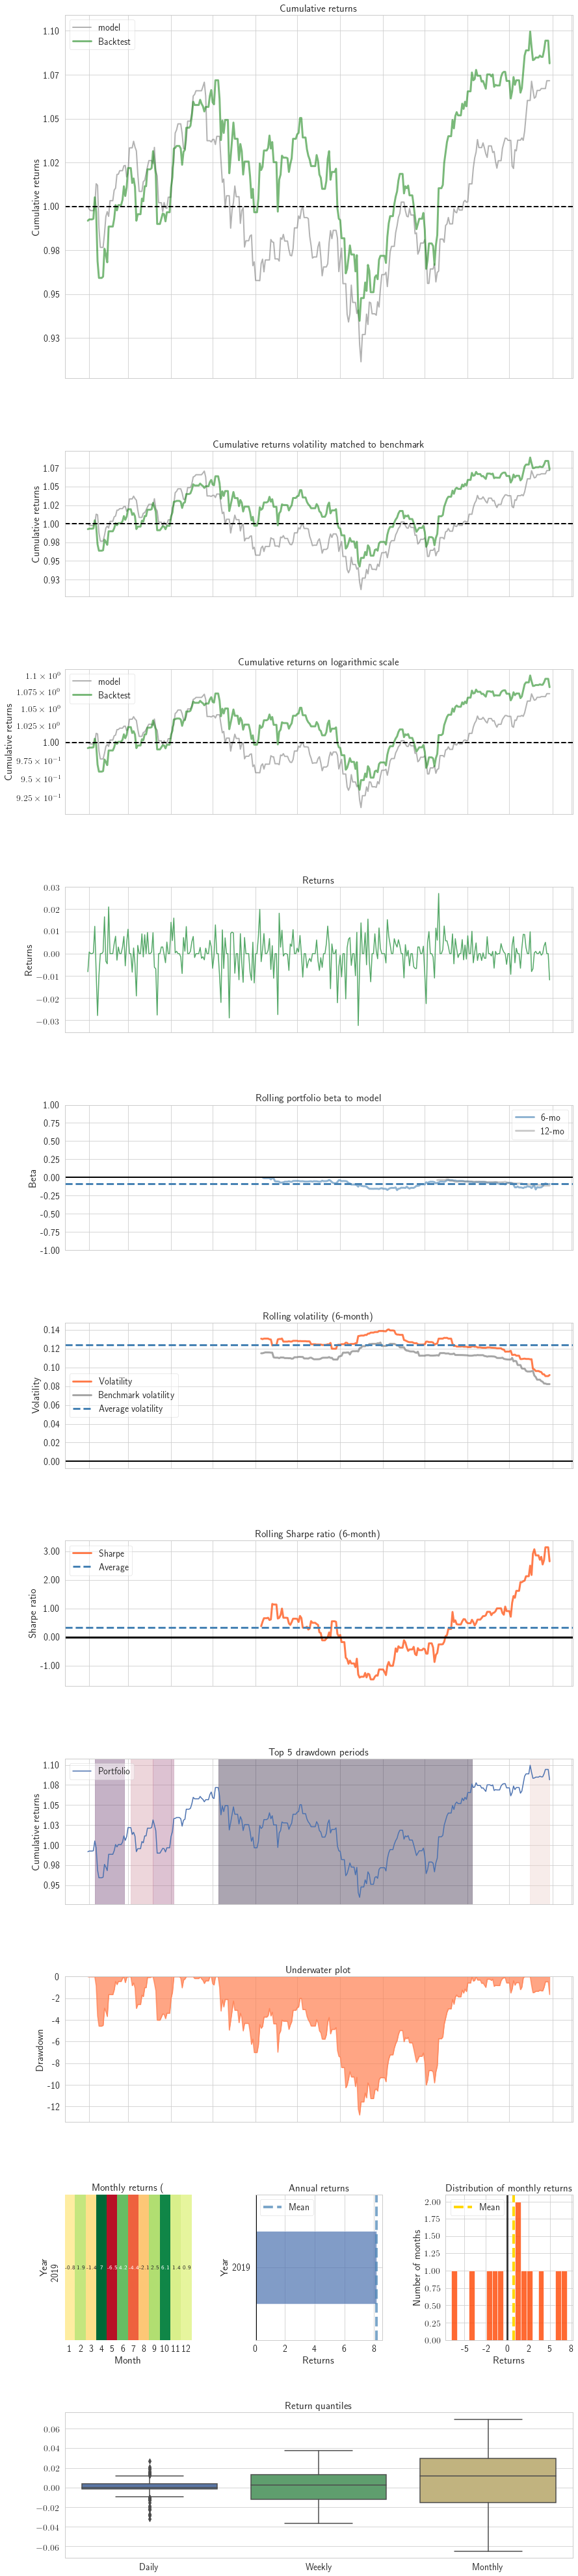

In [43]:
with pf.plotting.plotting_context("paper", font_scale=1.6 ):
    #plt.figure()
    sns.set_style("whitegrid")
    fig = pf.create_returns_tear_sheet(  ewg_bench  , benchmark_rets= r_model , set_context=False , return_fig = True)
    #sns.despine()
    fig.savefig('myimage.pdf', dpi=1200)
    #ax = fig.get_axes()[0]
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    
    #plt.plot()
#fig = pf.create_returns_tear_sheet(  r_model  , benchmark_rets= ewg_bench  , return_fig = True , set_context = True )

In [33]:


def plot_returns( r_model , r_etf , name = "model" , filename ="file"  ):
    # r_model -> series 
    sns.set()
    fig, ax = plt.subplots(figsize=(8,4))
    #ax = fig.add_axes([0, 0, 1, 1])
    r_model.name = "model"
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    model_sum = r_model.cumsum()
    etf_sum = r_etf.cumsum()
    
    df = pd.concat( [ model_sum , etf_sum ] , axis = 1 ).reset_index().fillna(0.0)
    df["diff"] = df["model"] - df[ etf_sum.name ] 

    sns.lineplot( x = "index" , y="model"    , data = df , ax = ax   )
    sns.lineplot( x = "index" , y=r_etf.name , data = df , ax = ax  )
    
    ax.set_ylabel( "Cumulative returns" )
    ax.set_xlabel( "Date")
    ax.legend( [ name  , r_etf.name ] , facecolor ="w" )
    #plt.savefig("./jiaaaaoo.pdf")
    fig.savefig("./cum_returns_{}.pdf".format(filename) , format="pdf")

    # DIFF
    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot( x = "index" , y="diff" , data = df , ax = ax  )
    ax.set_ylabel( "Difference( model - {})".format( r_etf.name ) )
    ax.set_xlabel( "Date" )
    ax.legend( ["{} - {}".format( name , r_etf.name ) ] )
    fig.savefig( "./difference_plot_{}.pdf".format(filename) , format = "pdf" )
    
    
    ## BOX PLOTS
    df["model100"] = df["model"]*100
    df['month'] = df['index'].dt.strftime('%b')
    
    fig, ax = plt.subplots( figsize =( 8 , 6 ))
    #fig.set_size_inches((12,4))
    sns.boxplot(x='month',y='model100',data=df,ax=ax)
    ax.set_xlabel( "Months" )
    ax.set_ylabel( "Returns($\%$)")
    ax.set_title( "Monthly return distribution")
    fig.savefig("./box_plot_model_{}.pdf".format( filename ) , format = "pdf" )
    plt.show()
    return "" 
    
def tensorboard_plots():
    
    disc = pd.read_csv("../data/tensorboard_logs/6M_reward_logreturn/discounted_rewards.csv")
    policy_loss = pd.read_csv( "../data/tensorboard_logs/6M_reward_logreturn/loss_policy_gradient_loss.csv")
    print( policy_loss.head() )
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    fig, ax = plt.subplots(figsize=(8,4))
    #ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
    
    sns.lineplot( x = "Step" , y="Value"    , data = disc , ax = ax    )
    ax.set_xlabel("Timestep")
    ax.set_ylabel(" Discounted reward average" )
    ax.legend( ["6M A2C "] )
    
    fig.savefig("./disc_rewards.pdf" , format ="pdf" )
    
    fig, ax = plt.subplots(figsize=(8,4))

    sns.lineplot( x = "Step" , y="Value" , data = policy_loss , ax = ax )
    ax.set_xlabel( "Timestep" ) 
    ax.set_ylabel("Policy loss" )
    ax.legend( ["6M A2C"] )
    
    fig.savefig("./policy_loss.pdf" , format ="pdf" )
    return "disc, policy_loss"

def rolling_sharpe(y):
    return np.sqrt(126) * (y.mean() / y.std())

def plot_sharpe_ratio( r_model , r_bench , name = "AC2 model" ):
        
    
    rolling_s_m = r_model.rolling('60d').apply( rolling_sharpe)
    rolling_s_bench = r_bench.rolling('60d').apply( rolling_sharpe)
    
    df = pd.concat( [  rolling_s_m , rolling_s_bench ] , axis = 1  ).reset_index().fillna(0.0)
    df.columns = [ "index" , "model" , r_bench.name ]
    df["diff"] = df["model"] - df[ r_bench.name ]
    df = df[30:]
    print( df.head())
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    fig, ax = plt.subplots(figsize=(9,4))
    
    sns.lineplot( x = "index" , y="model" , data = df , ax = ax )
    sns.lineplot( x = "index" , y= r_bench.name , data = df , ax = ax )
    ax.set_xlabel( "Date")
    ax.set_ylabel( "Rolling Sharpe ratio")
    ax.legend( [ name , r_bench.name ] )
    ax.set_title( "Rolling Sharpe ratio")
    fig.savefig("./rolling_sr_{}.pdf".format(   name.replace(" " , "")   ) , format = "pdf"  )
    
    
    # plot sharpe diff
    fig, ax = plt.subplots(figsize=(9,4))

    sns.lineplot( x = "index" , y="diff" , data = df , ax = ax )
    ax.set_xlabel( "Date")
    ax.set_ylabel( "Rolling Sharpe ratio")
    ax.set_title( "Difference rolling Sharpe ratio")
    ax.legend( [ "Difference - {} - {}".format( name , r_bench.name )  ] )
    
    fig.savefig("./rolling_sr_diff_{}.pdf".format(   name.replace(" " , "")   ) , format = "pdf"  )
    
    return 

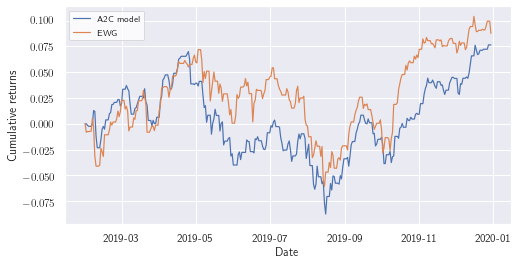

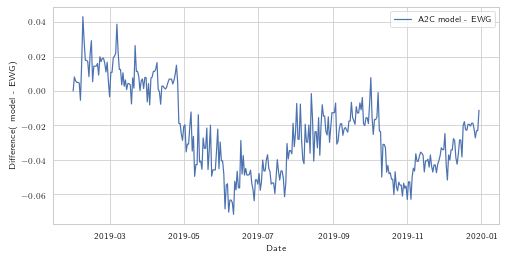

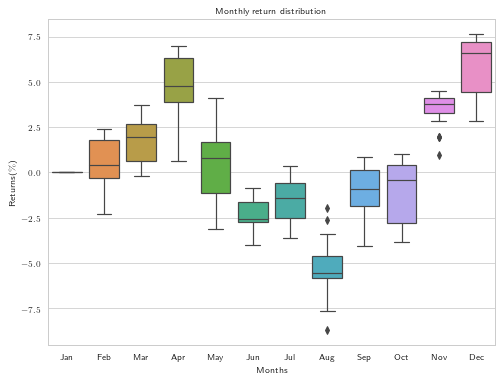

''

In [38]:
plot_returns( r_model , ewg_bench , name = "A2C model" , filename ="a2c" )

/home/afhuertas/miniconda3/envs/thesis2/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/home/afhuertas/miniconda3/envs/thesis2/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


        index     model       EWG      diff
30 2019-03-01  1.110617  0.968514  0.142102
31 2019-03-02  1.775690  0.953150  0.822539
32 2019-03-03  1.747041  0.938495  0.808546
33 2019-03-04  1.719736  0.575698  1.144038
34 2019-03-05  1.872861  0.667513  1.205348


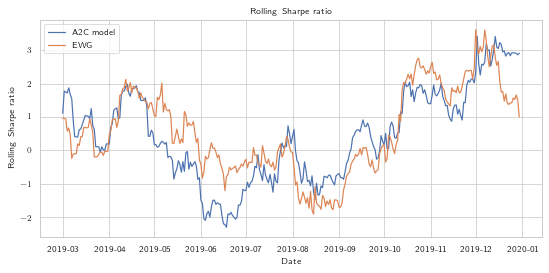

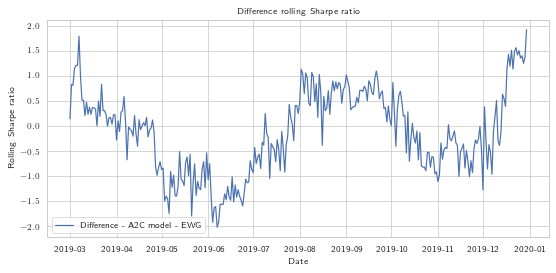

In [36]:
#plot_sharpe_ratio( r_model , ewg_bench )

plot_sharpe_ratio( r_model , ewg_bench , name = "A2C model"  ) 